In [1]:
# Imports necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

# Challenge 1

## Import multiple data and concat

In [2]:
# Uses year 2019 winter time (Jan, Feb)

urls = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_190105.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190112.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190119.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190126.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190202.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190209.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190216.txt",
        "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190223.txt"]

dfs = []
for u in urls:
    dfs.append(pd.read_csv(u))
df = pd.concat(dfs)

In [3]:
# Formats the names of the columns
df.columns = [c.strip() for c in df.columns]

In [4]:
# Prints the number of rows and columns
df.shape

(1623458, 11)

# Challenge 2

## Convert Date and TIME columns to datetime object

In [5]:
# Converts DATE and TIME columns into datetime objects
df_date_time = pd.to_datetime(df["DATE"]+" "+df["TIME"])
# Combines columns DATE and TIME into one and assigns them into column DATE_TIME
df["DATE_TIME"] = df_date_time
df["DATE"] = pd.to_datetime(df["DATE"])

# Drops the columns LINENAME, DIVISION and DESC
#df.drop(columns = ["LINENAME","DIVISION","DESC"], inplace = True)
df["WEEKDAYS"] = df["DATE_TIME"].dt.day_name()
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,WEEKDAYS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,03:00:00,REGULAR,6889287,2335920,2018-12-29 03:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,07:00:00,REGULAR,6889299,2335936,2018-12-29 07:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,11:00:00,REGULAR,6889364,2336038,2018-12-29 11:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,15:00:00,REGULAR,6889605,2336101,2018-12-29 15:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-12-29,19:00:00,REGULAR,6889966,2336173,2018-12-29 19:00:00,Saturday


# Challenge 3

## Group data s.t. it represents daily entries

In [6]:
# checking for duplicate
df.groupby(["C/A","UNIT","SCP","STATION","DATE_TIME"])["ENTRIES"].count().reset_index().sort_values("ENTRIES",ascending=False).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
61741,A046,R463,00-06-02,CANAL ST,2019-02-20 20:00:00,2
13125,A011,R080,01-00-04,57 ST-7 AV,2018-12-30 15:00:00,2
1111178,R158,R084,00-06-00,59 ST COLUMBUS,2019-01-14 03:00:00,2
565961,N196,R285,00-03-00,FAR ROCKAWAY,2019-01-05 19:00:00,2
12373,A011,R080,01-00-02,57 ST-7 AV,2018-12-30 15:00:00,2


In [7]:
mask = (df["C/A"] == "A011") & (df["UNIT"] == "R080") & (df["SCP"] == "01-00-04") & (df["STATION"] == "57 ST-7 AV") & (df["DATE_TIME"] == "2018-12-30 15:00:00")
df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,WEEKDAYS
1644,A011,R080,01-00-04,57 ST-7 AV,NQRW,BMT,2018-12-30,15:00:00,REGULAR,1092974,858812,2018-12-30 15:00:00,Sunday
1645,A011,R080,01-00-04,57 ST-7 AV,NQRW,BMT,2018-12-30,15:00:00,RECOVR AUD,2536577,2147872,2018-12-30 15:00:00,Sunday


In [8]:
df["DESC"].value_counts()

REGULAR       1616272
RECOVR AUD       7186
Name: DESC, dtype: int64

In [9]:
# Get rid of the duplicate entry
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [10]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending = False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-12-29 03:00:00,1
1082296,R139,R031,04-06-00,34 ST-PENN STA,2019-01-01 07:00:00,1
1082294,R139,R031,04-06-00,34 ST-PENN STA,2018-12-31 23:00:00,1
1082293,R139,R031,04-06-00,34 ST-PENN STA,2018-12-31 19:00:00,1
1082292,R139,R031,04-06-00,34 ST-PENN STA,2018-12-31 15:00:00,1


In [11]:
df["DESC"].value_counts()

REGULAR       1616272
RECOVR AUD       7159
Name: DESC, dtype: int64

The number of observations with RECOVER AUD decreased

In [12]:
df_MTA_byDate = (df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index = False).ENTRIES.first())

In [13]:
#Prints the daily entries for each turnstile
df_MTA_byDate[["PREV_DATE", "PREV_ENTRIES"]] = (df_MTA_byDate.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))
df_MTA_byDate.head(10)

<ipython-input-13-858424a4adfd>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_MTA_byDate[["PREV_DATE", "PREV_ENTRIES"]] = (df_MTA_byDate.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"].apply(lambda grp: grp.shift(1)))


,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,2018-12-29,6890186,NaT,NaN
1,A002,R051,02-00-00,59 ST,2018-12-30,6890894,2018-12-29,6890186.0
2,A002,R051,02-00-00,59 ST,2018-12-31,6891946,2018-12-30,6890894.0
3,A002,R051,02-00-00,59 ST,2019-01-01,6892430,2018-12-31,6891946.0
4,A002,R051,02-00-00,59 ST,2019-01-02,6893894,2019-01-01,6892430.0
5,A002,R051,02-00-00,59 ST,2019-01-03,6895434,2019-01-02,6893894.0
6,A002,R051,02-00-00,59 ST,2019-01-04,6896974,2019-01-03,6895434.0
7,A002,R051,02-00-00,59 ST,2019-01-05,6897740,2019-01-04,6896974.0
8,A002,R051,02-00-00,59 ST,2019-01-06,6898382,2019-01-05,6897740.0
9,A002,R051,02-00-00,59 ST,2019-01-07,6899906,2019-01-06,6898382.0


In [14]:
df_MTA_byDate.dropna(axis=0, inplace=True)
df_MTA_byDate.head(15)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,2018-12-30,6890894,2018-12-29,6890186.0
2,A002,R051,02-00-00,59 ST,2018-12-31,6891946,2018-12-30,6890894.0
3,A002,R051,02-00-00,59 ST,2019-01-01,6892430,2018-12-31,6891946.0
4,A002,R051,02-00-00,59 ST,2019-01-02,6893894,2019-01-01,6892430.0
5,A002,R051,02-00-00,59 ST,2019-01-03,6895434,2019-01-02,6893894.0
6,A002,R051,02-00-00,59 ST,2019-01-04,6896974,2019-01-03,6895434.0
7,A002,R051,02-00-00,59 ST,2019-01-05,6897740,2019-01-04,6896974.0
8,A002,R051,02-00-00,59 ST,2019-01-06,6898382,2019-01-05,6897740.0
9,A002,R051,02-00-00,59 ST,2019-01-07,6899906,2019-01-06,6898382.0
10,A002,R051,02-00-00,59 ST,2019-01-08,6901408,2019-01-07,6899906.0


In [15]:
# Plots the daily time series for a single turnstile
df_MTA_byDate["daily_entries"] = df_MTA_byDate["ENTRIES"] - df_MTA_byDate["PREV_ENTRIES"]
df_MTA_byDate.head(15)

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,daily_entries
1,A002,R051,02-00-00,59 ST,2018-12-30,6890894,2018-12-29,6890186.0,708.0
2,A002,R051,02-00-00,59 ST,2018-12-31,6891946,2018-12-30,6890894.0,1052.0
3,A002,R051,02-00-00,59 ST,2019-01-01,6892430,2018-12-31,6891946.0,484.0
4,A002,R051,02-00-00,59 ST,2019-01-02,6893894,2019-01-01,6892430.0,1464.0
5,A002,R051,02-00-00,59 ST,2019-01-03,6895434,2019-01-02,6893894.0,1540.0
6,A002,R051,02-00-00,59 ST,2019-01-04,6896974,2019-01-03,6895434.0,1540.0
7,A002,R051,02-00-00,59 ST,2019-01-05,6897740,2019-01-04,6896974.0,766.0
8,A002,R051,02-00-00,59 ST,2019-01-06,6898382,2019-01-05,6897740.0,642.0
9,A002,R051,02-00-00,59 ST,2019-01-07,6899906,2019-01-06,6898382.0,1524.0
10,A002,R051,02-00-00,59 ST,2019-01-08,6901408,2019-01-07,6899906.0,1502.0


In [16]:
mask = (df_MTA_byDate["C/A"] == "A002") & (df_MTA_byDate["UNIT"] == "R051") & (df_MTA_byDate["SCP"] == '02-00-00') & (df_MTA_byDate["STATION"] == "59 ST") 
df_MTA_byDate[mask].shape

# Defines a masked dataframe
masked_df = df_MTA_byDate[mask].sort_values("DATE")

# Drops ENTRIES column and reset index so it is single indexed
masked_df.drop(columns = "ENTRIES", inplace = True)
masked_df.head(20)

,C/A,UNIT,SCP,STATION,DATE,PREV_DATE,PREV_ENTRIES,daily_entries
1,A002,R051,02-00-00,59 ST,2018-12-30,2018-12-29,6890186.0,708.0
2,A002,R051,02-00-00,59 ST,2018-12-31,2018-12-30,6890894.0,1052.0
3,A002,R051,02-00-00,59 ST,2019-01-01,2018-12-31,6891946.0,484.0
4,A002,R051,02-00-00,59 ST,2019-01-02,2019-01-01,6892430.0,1464.0
5,A002,R051,02-00-00,59 ST,2019-01-03,2019-01-02,6893894.0,1540.0
6,A002,R051,02-00-00,59 ST,2019-01-04,2019-01-03,6895434.0,1540.0
7,A002,R051,02-00-00,59 ST,2019-01-05,2019-01-04,6896974.0,766.0
8,A002,R051,02-00-00,59 ST,2019-01-06,2019-01-05,6897740.0,642.0
9,A002,R051,02-00-00,59 ST,2019-01-07,2019-01-06,6898382.0,1524.0
10,A002,R051,02-00-00,59 ST,2019-01-08,2019-01-07,6899906.0,1502.0


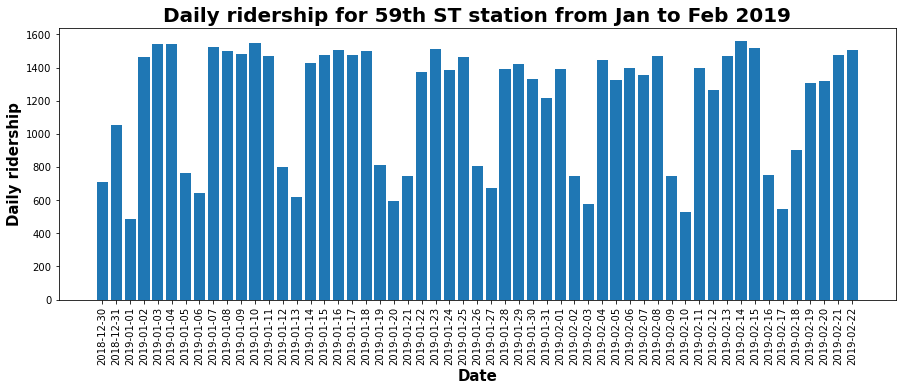

In [17]:
plt.figure(figsize = (15,5))
# Plots a bar graph of a entry number of specific turnstile by date
plt.bar(masked_df["DATE"], masked_df["daily_entries"], tick_label = masked_df["DATE"].apply(lambda x: str(x).split(" ")[0]))
# Makes the text of x axis so they don't overlap
plt.xticks(rotation = 90)
plt.title("Daily ridership for 59th ST station from Jan to Feb 2019", weight = "bold", size = 20)
plt.xlabel("Date", weight = "bold", size = 15)
plt.ylabel("Daily ridership", weight = "bold", size = 15);

In [18]:
df_MTA_byDate["daily_entries"].sort_values(ascending = False)

225673    1.869545e+09
244171    1.834119e+09
207556    1.255126e+09
174096    1.133281e+09
218008    9.859820e+08
              ...     
60641    -1.276366e+09
2017     -1.562636e+09
41080    -1.629649e+09
2073     -1.663107e+09
10029    -1.949563e+09
Name: daily_entries, Length: 264008, dtype: float64

In [19]:
len(df_MTA_byDate[abs(df_MTA_byDate["daily_entries"]) > 1000000])

102

In [20]:
def get_daily_entries(row, max_counter = 10000):
    if row["daily_entries"] < 0:
        row["daily_entries"] = -row["daily_entries"]
        
    if row["daily_entries"] > max_counter:
        return 0
    return row["daily_entries"]

df_MTA_byDate["daily_entries"] = df_MTA_byDate.apply(get_daily_entries, axis = 1)

In [21]:
df_MTA_byDate.daily_entries.describe()

count    264008.000000
mean        967.501420
std         948.050966
min           0.000000
25%         227.000000
50%         722.000000
75%        1439.000000
max        9641.000000
Name: daily_entries, dtype: float64

In [22]:
# Combines the turnstiles with C/A, UNIT and STATION.
station = ["C/A","UNIT","STATION"]

# Prints the combined number of turnstiles for each day 
df_MTA_station_byDate = df_MTA_byDate.groupby(station+["DATE"])["daily_entries"].sum().reset_index()

In [23]:
# Renames the column max_min to TOTAL_ENTRIES
df_MTA_station_byDate.rename(columns = {"daily_entries": "TOTAL_ENTRIES"}, inplace=True)
df_MTA_station_byDate.head(15)

,C/A,UNIT,STATION,DATE,TOTAL_ENTRIES
0,A002,R051,59 ST,2018-12-30,7270.0
1,A002,R051,59 ST,2018-12-31,9294.0
2,A002,R051,59 ST,2019-01-01,5325.0
3,A002,R051,59 ST,2019-01-02,12864.0
4,A002,R051,59 ST,2019-01-03,13464.0
5,A002,R051,59 ST,2019-01-04,13296.0
6,A002,R051,59 ST,2019-01-05,8130.0
7,A002,R051,59 ST,2019-01-06,6988.0
8,A002,R051,59 ST,2019-01-07,12820.0
9,A002,R051,59 ST,2019-01-08,13153.0


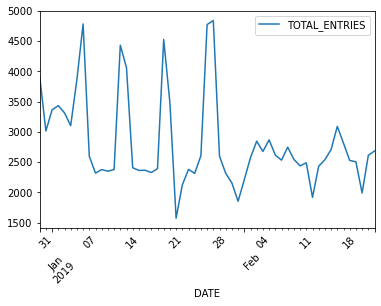

In [24]:
# Plots the daily time series for the specific station
df_MTA_station_byDate[df_MTA_station_byDate["STATION"] == "RIT-ROOSEVELT"].plot(x="DATE",y="TOTAL_ENTRIES", rot=45)
plt.savefig('MTA_station_byDate.png')

In [25]:
# Makes a list of counts for several weeks 
df_MTA_c8 = df_MTA_byDate.groupby(["STATION","DATE"]).sum("daily_entries").reset_index()
df_MTA_c8["DATE"] = pd.to_datetime(df_MTA_c8["DATE"])
df_MTA_c8["dow"] = df_MTA_c8["DATE"].dt.day_name()
df_MTA_c8.head(15)

,STATION,DATE,ENTRIES,PREV_ENTRIES,daily_entries,dow
0,1 AV,2018-12-30,3041077967,3.041066e+09,11989.0,Sunday
1,1 AV,2018-12-31,3041092753,3.041078e+09,14786.0,Monday
2,1 AV,2019-01-01,3041102742,3.041093e+09,9989.0,Tuesday
3,1 AV,2019-01-02,3041121218,3.041103e+09,18476.0,Wednesday
4,1 AV,2019-01-03,3041141084,3.041121e+09,19866.0,Thursday
5,1 AV,2019-01-04,3041161473,3.041141e+09,20389.0,Friday
6,1 AV,2019-01-05,3041175403,3.041161e+09,13930.0,Saturday
7,1 AV,2019-01-06,3041187424,3.041175e+09,12021.0,Sunday
8,1 AV,2019-01-07,3041206962,3.041187e+09,19538.0,Monday
9,1 AV,2019-01-08,3041227376,3.041207e+09,20414.0,Tuesday


In [26]:
# Creates a list of counts for one specific station
df_MTA_c8sub = df_MTA_c8[df_MTA_c8.STATION == "34 ST-PENN STA"].sort_values("DATE")
df_MTA_c8sub.head(15)

,STATION,DATE,ENTRIES,PREV_ENTRIES,daily_entries,dow
3355,34 ST-PENN STA,2018-12-30,3850058723,3.849976e+09,84869.0,Sunday
3356,34 ST-PENN STA,2018-12-31,3850170029,3.850059e+09,113628.0,Monday
3357,34 ST-PENN STA,2019-01-01,3850235229,3.850170e+09,66386.0,Tuesday
3358,34 ST-PENN STA,2019-01-02,3850393220,3.850235e+09,161139.0,Wednesday
3359,34 ST-PENN STA,2019-01-03,3850555923,3.850393e+09,165817.0,Thursday
3360,34 ST-PENN STA,2019-01-04,3850712735,3.850556e+09,159750.0,Friday
3361,34 ST-PENN STA,2019-01-05,3850786862,3.850713e+09,75019.0,Saturday
3362,34 ST-PENN STA,2019-01-06,3850852455,3.850787e+09,66389.0,Sunday
3363,34 ST-PENN STA,2019-01-07,3851011777,3.850852e+09,161898.0,Monday
3364,34 ST-PENN STA,2019-01-08,3851174475,3.851012e+09,165268.0,Tuesday


In [27]:
df_MTA_c8plot = df_MTA_c8sub.iloc[6: , ]
df_MTA_c8plot.head(6)

,STATION,DATE,ENTRIES,PREV_ENTRIES,daily_entries,dow
3361,34 ST-PENN STA,2019-01-05,3850786862,3.850713e+09,75019.0,Saturday
3362,34 ST-PENN STA,2019-01-06,3850852455,3.850787e+09,66389.0,Sunday
3363,34 ST-PENN STA,2019-01-07,3851011777,3.850852e+09,161898.0,Monday
3364,34 ST-PENN STA,2019-01-08,3851174475,3.851012e+09,165268.0,Tuesday
3365,34 ST-PENN STA,2019-01-09,3851338064,3.851174e+09,166763.0,Wednesday
3366,34 ST-PENN STA,2019-01-10,3851505465,3.851338e+09,170079.0,Thursday


In [28]:
entries_day = df_MTA_c8plot.daily_entries.values
dates = df_MTA_c8sub.DATE.values
days = ["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"]

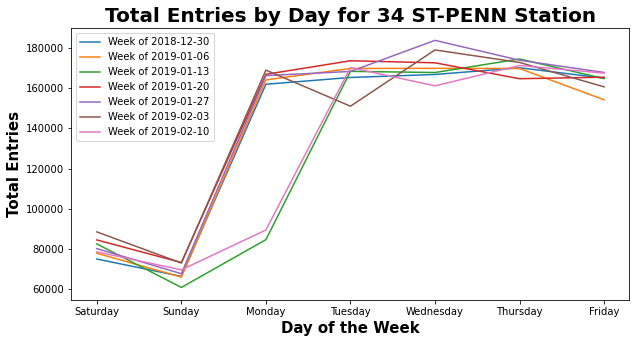

In [29]:
# Plots the weekly commute numbers
plt.figure(figsize = (10,5))

labels = []
for i in range(7):
  plt.plot(list(range(7)), entries_day[i*7 : (i+1)*7])
  labels.append('Week of ' + str(dates[i*7]).split("T")[0])

plt.title("Total Entries by Day for 34 ST-PENN Station", weight = "bold", size = 20)
plt.xticks(range(7), days)
plt.xlabel("Day of the Week", weight = "bold", size = 15)
plt.ylabel("Total Entries", weight = "bold", size = 15)
plt.legend(labels, loc = "best");

In [30]:
# Sums the total number of rides for each station
total_2mon = df_MTA_c8.groupby("STATION")["daily_entries"].sum().sort_values(ascending=False).reset_index()
total_2mon.rename(columns = {"daily_entries":"Total_Entries"},inplace = True)
total_2mon.head(15)

,STATION,Total_Entries
0,34 ST-PENN STA,7506369.0
1,GRD CNTRL-42 ST,6602761.0
2,34 ST-HERALD SQ,5583608.0
3,23 ST,5162608.0
4,42 ST-PORT AUTH,4760195.0
5,14 ST-UNION SQ,4605503.0
6,TIMES SQ-42 ST,4436083.0
7,FULTON ST,4057021.0
8,86 ST,3818741.0
9,125 ST,3524747.0


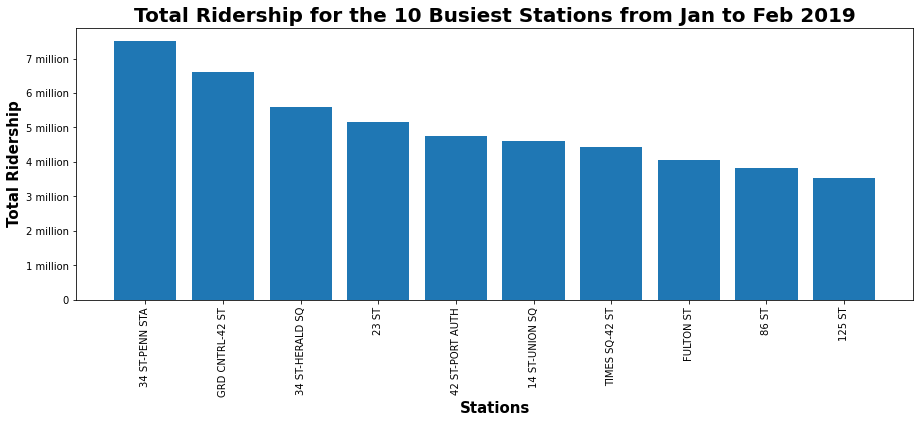

In [31]:
labels = ["0", "1 million", "2 million", "3 million", "4 million", "5 million", "6 million", "7 million" ]

# Plots the list of the total number of rides' values
plt.figure(figsize = (15, 5))
plt.bar(total_2mon.STATION[:10],total_2mon.Total_Entries[:10])
plt.title("Total Ridership for the 10 Busiest Stations from Jan to Feb 2019", weight = "bold", size = 20)
plt.xlabel("Stations", weight = "bold", size = 15)
plt.xticks(ticks = list(range(10)), labels = total_2mon.STATION[:10], rotation = 90)
plt.yticks(ticks = list(range(0, 8000000, 1000000)), labels = labels) 
plt.ylabel("Total Ridership", weight = "bold", size = 15);

In [32]:
# Creates a new column called STATION_COMPLETE which combines C/A, UNIT and STATION columns 
df_MTA_station_byDate["STATION_COMPLETE"] = df_MTA_station_byDate["C/A"] + " " + \
                                            df_MTA_station_byDate["UNIT"] + " " + \
                                            df_MTA_station_byDate["STATION"]

In [33]:
# Removes all rows for stations with incomplete data

# Creates a dataframe of counts by STATION_COMPLETE
station_counts = df_MTA_station_byDate["STATION_COMPLETE"].value_counts().rename_axis("STATION_COMPLETE").reset_index(name="COUNT")

# Creates a series that contains only stations that have the count equal to the max (i.e. 55)
complete_stations = station_counts.loc[station_counts["COUNT"]==station_counts["COUNT"].max(), "STATION_COMPLETE"]

# Deletes all rows with stations that are not in 'complete_stations' (i.e. not complete)
arima_df = df_MTA_station_byDate[df_MTA_station_byDate["STATION_COMPLETE"].isin(complete_stations)]

# Prints value counts to confirm that all are equal
arima_df["STATION_COMPLETE"].value_counts()

arima_df["DATE"] = pd.to_datetime(arima_df["DATE"])

<ipython-input-33-26be31beeb2c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_df["DATE"] = pd.to_datetime(arima_df["DATE"])


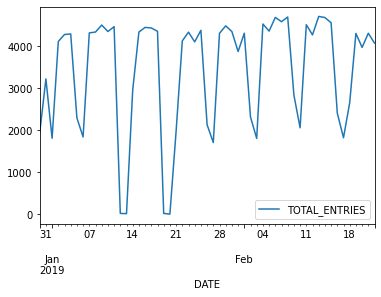

In [34]:
# Subsets the dataframe to include one station
time_series = arima_df[arima_df["STATION_COMPLETE"]=="R641 R210 BEVERLY RD"]
# Plots one station 
time_series.plot(x="DATE",y="TOTAL_ENTRIES")
plt.savefig('station_complete.png')

In [35]:
# Creates a series that contains total entries for the station
time_series_entries = time_series["TOTAL_ENTRIES"]
# Sets the index with day ("d") frequency
time_series_entries.index = time_series["DATE"].dt.to_period("d")
# Splits the data into train and test sets (series) - test contains last 7 days
time_series_entries_train = time_series_entries[:-7]
time_series_entries_test = time_series_entries[len(time_series_entries)-7:]

                               SARIMAX Results                                
Dep. Variable:          TOTAL_ENTRIES   No. Observations:                   48
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -397.368
Date:                Thu, 07 Jan 2021   AIC                            806.735
Time:                        23:43:47   BIC                            817.836
Sample:                    12-30-2018   HQIC                           810.913
                         - 02-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2736      0.135     -2.021      0.043      -0.539      -0.008
ar.L2         -0.5459      0.118     -4.618      0.000      -0.778      -0.314
ar.L3         -0.4606      0.154     -2.983      0.0

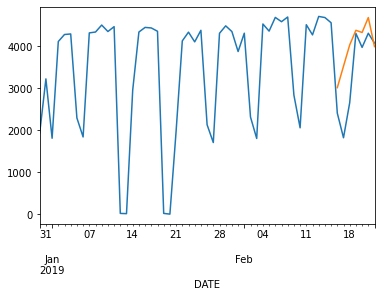

In [36]:
# Creates an ARIMA model for one station
model = ARIMA(time_series_entries_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())
time_series_entries_forecast = model_fit.forecast(steps=7)
time_series_entries.plot()
time_series_entries_forecast.plot()
plt.savefig('arima.png')

In [44]:
# Creates ARIMA models for each station and saves to a dataframe
arima_df_predictions = pd.DataFrame(columns=["DATE","STATION","PREDICTED_ENTRIES"])
for station in complete_stations:
    # Subsets the dataframe to include only the station
    time_series = arima_df[arima_df["STATION_COMPLETE"]==station]
    # Creates a series that contains total entries for the station
    time_series_entries = time_series["TOTAL_ENTRIES"]
    # Sets the index with day ("d") frequency
    time_series_entries.index = time_series["DATE"].dt.to_period("d")
    # Creates a model
    model = ARIMA(time_series_entries, order=(5,1,0))
    # Fits the model
    model_fit = model.fit()
    # Forecass for 7 days
    time_series_entries_forecast = model_fit.forecast(steps=7)
    # Convers the forecast to dataframe
    temp_df = pd.DataFrame(time_series_entries_forecast)
    # Renames and resets the index
    temp_df.index.name = "DATE"
    temp_df.reset_index(inplace=True)
    # Renames the predicted mean column
    temp_df.rename(columns={"predicted_mean":"PREDICTED_ENTRIES"}, inplace=True)
    # Rounds the predicted entries
    temp_df["PREDICTED_ENTRIES"] = temp_df["PREDICTED_ENTRIES"].round()
    # Adds the station column
    temp_df["STATION"] = station
    # Appends the temporary dataframe to arima_df_predictions
    arima_df_predictions = arima_df_predictions.append(temp_df)

In [51]:
day = arima_df_predictions["DATE"].min()
arima_df_predictions[arima_df_predictions["DATE"]==day].sort_values("PREDICTED_ENTRIES", ascending=False).head(10)

,DATE,STATION,PREDICTED_ENTRIES
0,2019-02-23,PTH22 R540 PATH NEW WTC,36442.0
0,2019-02-23,R238 R046 GRD CNTRL-42 ST,35505.0
0,2019-02-23,R533 R055 FLUSHING-MAIN,34240.0
0,2019-02-23,R138 R293 34 ST-PENN STA,33647.0
0,2019-02-23,N324 R018 JKSN HT-ROOSVLT,31682.0
0,2019-02-23,R221 R170 14 ST-UNION SQ,30198.0
0,2019-02-23,N051 R084 59 ST COLUMBUS,30135.0
0,2019-02-23,N506 R022 34 ST-HERALD SQ,28975.0
0,2019-02-23,N063A R011 42 ST-PORT AUTH,27279.0
0,2019-02-23,A025 R023 34 ST-HERALD SQ,26469.0
